## **Mount Google Drive**

In [24]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Load the Library

In [1]:
!pip install torch torchvision medmnist
!pip install --upgrade matplotlib
!pip install torchinfo

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO
import os, time, tqdm
import torch.nn.functional as F

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

Using device: cuda:0


##Pre-processing the data

In [5]:
#importing three datasets
"""
PathMNIST:
Facts of PathMNIST
Data Modality: Colon Pathology
Task: Multi-Class (9)
Number of Samples: 107,180 (89,996 / 10,004 / 7,180)
-------

ChestMNIST:
Data Modality: Chest X-Ray
Task: Multi-Label (14) Binary-Class (2)
Number of Samples: 112,120 (78,468 / 11,219 / 22,433)

PneumoniaMNIST:
Data Modality: Chest X-Ray
Task: Binary-Class (2)
Number of Samples: 5,856 (4,708 / 524 / 624

BloodMNIST:
Data Modality: Blood Cell Microscope
Task: Multi-Class (8)
Number of Samples: 17,092 (11,959 / 1,712 / 3,421)

DermaMNIST:
Data Modality: Dermatoscope
Task: Multi-Class (7)
Number of Samples: 10,015 (7,007 / 1,003 / 2,005)
"""
# transforms
def crop(x, low, high):
    x[x<=low] = low
    x[x>=high] = high
    return x

transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    transforms.Lambda(lambda x: crop(x, 0., 1.))
])


from medmnist import PathMNIST, ChestMNIST, BloodMNIST, PneumoniaMNIST, DermaMNIST
path_dataset = PathMNIST(split="train",download=True, transform = transform,  target_transform= lambda x : 0 if x > 0 else -1)
# chest_dataset = ChestMNIST(split="train",download=True)
blood_dataset = BloodMNIST(split="train",download=True, transform = transform, target_transform= lambda x : 1 if x > 0 else -1)
# pneumonia_dataset = PneumoniaMNIST(split="train",download=True)
derma_dataset = DermaMNIST(split="train",download=True, transform = transform, target_transform= lambda x : 2 if x > 0 else -1)


100%|██████████| 205615438/205615438 [00:01<00:00, 151906963.05it/s]


100%|██████████| 35461855/35461855 [00:00<00:00, 101956771.08it/s]


100%|██████████| 19725078/19725078 [00:00<00:00, 70427164.65it/s]


In [6]:
print(path_dataset)
print(blood_dataset)
print(derma_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K

In [7]:
concat_dataset = torch.utils.data.ConcatDataset([
                                           path_dataset,
                                           derma_dataset,
                                           blood_dataset
                                        ])

In [8]:
def filter_fn(x, l):
    if l == -1:
        return False
    return True


In [9]:
class FilteredDataset(Dataset):
    def __init__(self, original_dataset, filter_fn):
        """
        Args:
            original_dataset (Dataset): The original dataset to filter.
            filter_fn (function): A function that takes (img, label, extra_label) as input and returns True if the sample should be included.
        """
        self.original_dataset = original_dataset
        self.indices = [i for i in range(len(original_dataset)) if filter_fn(*original_dataset[i])]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.original_dataset[self.indices[idx]]


In [10]:
final_dataset = FilteredDataset(concat_dataset, filter_fn)

# DataLoader

In [11]:
train_loader = DataLoader(dataset=final_dataset, batch_size=128, shuffle=True)

In [12]:

# #MedMNIST dataset (Pathology test)
# data_flag = 'pathmnist'
# download = True

# #dataset info
# info = INFO[data_flag]
# DataClass = getattr(medmnist, info['python_class'])
# print(info)

# # transforms
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

# # Load datasets
# train_dataset = DataClass(split='train', transform=transform, download=download)
# test_dataset = DataClass(split='test', transform=transform, download=download)

# train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

### **Vanila VAE Model**

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        x_hat = self.sigmoid(self.fc2(h))
        return x_hat

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

    def loss_function(self, x_hat, x, mu, logvar):
        recon_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div

## Conditional VAE Model:

In [14]:
# https://github.com/chendaichao/VAE-pytorch/blob/master/Models/VAE/train_cVAE.py
import torch
import numpy as np
import torch.nn as nn
from collections import OrderedDict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class MLP(nn.Module):
    def __init__(self, hidden_size, last_activation = True):
        super(MLP, self).__init__()
        q = []
        for i in range(len(hidden_size)-1):
            in_dim = hidden_size[i]
            out_dim = hidden_size[i+1]
            q.append(("Linear_%d" % i, nn.Linear(in_dim, out_dim)))
            if (i < len(hidden_size)-2) or ((i == len(hidden_size) - 2) and (last_activation)):
                q.append(("BatchNorm_%d" % i, nn.BatchNorm1d(out_dim)))
                q.append(("ReLU_%d" % i, nn.ReLU(inplace=True)))
        self.mlp = nn.Sequential(OrderedDict(q))
    def forward(self, x):
        return self.mlp(x)

class Encoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Encoder, self).__init__()
        c, h, w = shape
        ww = ((w-8)//2 - 4)//2
        hh = ((h-8)//2 - 4)//2
        self.encode = nn.Sequential(nn.Conv2d(c, 16, 5, padding = 0), nn.BatchNorm2d(16), nn.ReLU(inplace = True),
                                    nn.Conv2d(16, 32, 5, padding = 0), nn.BatchNorm2d(32), nn.ReLU(inplace = True),
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(32, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True),
                                    nn.Conv2d(64, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True),
                                    nn.MaxPool2d(2, 2),
                                    Flatten(), MLP([ww*hh*64, 256, 128])
                                   )
        self.calc_mean = MLP([128+ncond, 64, nhid], last_activation = False)
        self.calc_logvar = MLP([128+ncond, 64, nhid], last_activation = False)

    def forward(self, x, y = None):
        x = self.encode(x)
        if (y is None):
            return self.calc_mean(x), self.calc_logvar(x)
        else:
            return self.calc_mean(torch.cat((x, y), dim=1)), self.calc_logvar(torch.cat((x, y), dim=1))

class Decoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Decoder, self).__init__()
        c, w, h = shape
        self.shape = shape
        self.decode = nn.Sequential(MLP([nhid+ncond, 64, 128, 256, c*w*h], last_activation = False), nn.Sigmoid())

    def forward(self, z, y = None):
        c, w, h = self.shape
        if (y is None):
            return self.decode(z).view(-1, c, w, h)
        else:
            return self.decode(torch.cat((z, y), dim=1)).view(-1, c, w, h)

# class VAE(nn.Module):
#     def __init__(self, shape, nhid = 16):
#         super(VAE, self).__init__()
#         self.dim = nhid
#         self.encoder = Encoder(shape, nhid)
#         self.decoder = Decoder(shape, nhid)

#     def sampling(self, mean, logvar):
#         eps = torch.randn(mean.shape).to(device)
#         sigma = 0.5 * torch.exp(logvar)
#         return mean + eps * sigma

#     def forward(self, x):
#         mean, logvar = self.encoder(x)
#         z = self.sampling(mean, logvar)
#         return self.decoder(z), mean, logvar

#     def generate(self, batch_size = None):
#         z = torch.randn((batch_size, self.dim)).to(device) if batch_size else torch.randn((1, self.dim)).to(device)
#         res = self.decoder(z)
#         if not batch_size:
#             res = res.squeeze(0)
#         return res

class cVAE(nn.Module):
    def __init__(self, shape, nclass, nhid = 16, ncond = 16):
        super(cVAE, self).__init__()
        self.dim = nhid
        self.encoder = Encoder(shape, nhid, ncond = ncond)
        self.decoder = Decoder(shape, nhid, ncond = ncond)
        self.label_embedding = nn.Embedding(nclass, ncond)

    def sampling(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma

    def forward(self, x, y):
        y = self.label_embedding(y)
        mean, logvar = self.encoder(x, y)
        z = self.sampling(mean, logvar)
        return self.decoder(z, y), mean, logvar

    def generate(self, class_idx):
        if (type(class_idx) is int):
            class_idx = torch.tensor(class_idx)
        class_idx = class_idx.to(device)
        if (len(class_idx.shape) == 0):
            batch_size = None
            class_idx = class_idx.unsqueeze(0)
            z = torch.randn((1, self.dim)).to(device)
        else:
            batch_size = class_idx.shape[0]
            z = torch.randn((batch_size, self.dim)).to(device)
        y = self.label_embedding(class_idx)
        res = self.decoder(z, y)
        if not batch_size:
            res = res.squeeze(0)
        return res

BCE_loss = nn.BCELoss(reduction = "sum")
def loss(X, X_hat, mean, logvar):
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
    return reconstruction_loss + KL_divergence

### **Conditional VAE Model Initialisation**

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = cVAE(shape = (3, 28, 28), nclass= 3, nhid = 2, ncond = 16)
net.to(device)
print(net)
save_name = "cVAE.pt"



cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

## **Init Optimizer**

In [16]:
lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

retrain = True
save_name = "/content/drive/My Drive/TUDa/Semester1/DeepDGM/cVAE/checkpoints/model_checkpoint.pth"
if os.path.exists(save_name):
    print("Model parameters have already been trained before. Retrain ? (y/n)")
    ans = input()
    if not (ans == 'y'):
        checkpoint = torch.load(save_name, map_location = device)
        net.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        for g in optimizer.param_groups:
            g['lr'] = lr

In [26]:
max_epochs = 50
# early_stop = EarlyStop(patience = 20, save_name = save_name)
net = net.to(device)

## **Training**

In [18]:
import time
def train(net, device, max_epochs, train_loader, optimizer):
    print("training on ", device)
    for epoch in range(max_epochs):

        train_loss, n, start = 0.0, 0, time.time()
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            X_hat, mean, logvar = net(X, y)

            l = loss(X, X_hat, mean, logvar).to(device)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            train_loss += l.cpu().item()
            n += X.shape[0]

        train_loss /= n
        print('epoch %d, train loss %.4f , time %.1f sec'
            % (epoch, train_loss, time.time() - start))

        adjust_lr(optimizer)


In [27]:
train(net, device, max_epochs, train_loader, optimizer)

training on  cuda
epoch 0, train loss 1209.1242 , time 49.4 sec
epoch 1, train loss 1208.9927 , time 46.4 sec
epoch 2, train loss 1207.9015 , time 47.8 sec
epoch 3, train loss 1208.1341 , time 48.0 sec
epoch 4, train loss 1207.5987 , time 47.4 sec
epoch 5, train loss 1207.1670 , time 47.2 sec
epoch 6, train loss 1206.5887 , time 48.9 sec
epoch 7, train loss 1206.9083 , time 46.5 sec
epoch 8, train loss 1206.6822 , time 46.6 sec
epoch 9, train loss 1206.6401 , time 46.1 sec
epoch 10, train loss 1205.9170 , time 46.9 sec
epoch 11, train loss 1205.8740 , time 46.4 sec
epoch 12, train loss 1205.5315 , time 46.2 sec
epoch 13, train loss 1205.7251 , time 46.9 sec
epoch 14, train loss 1205.8232 , time 47.2 sec
epoch 15, train loss 1205.3863 , time 47.0 sec
epoch 16, train loss 1204.8390 , time 45.8 sec
epoch 17, train loss 1204.6791 , time 46.3 sec
epoch 18, train loss 1204.5513 , time 47.8 sec
epoch 19, train loss 1204.5310 , time 46.3 sec
epoch 20, train loss 1204.4129 , time 46.8 sec
epoch

## **Mount Drive to save checkpoint**

## **Save Model**

In [20]:
def save_model(model, optimizer, path='model_checkpoint.pth'):
    """
    Save the model and optimizer state to a file.

    Parameters:
    - model: The PyTorch model to save.
    - optimizer: The optimizer used for training the model.
    - epoch: The current training epoch.
    - loss: The loss at the time of saving.
    - path: The file path to save the checkpoint.
    """

    %cd /content/drive/My Drive/TUDa/Semester1/DeepDGM/cVAE/checkpoints/
    torch.save({
        # 'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        # 'loss': loss,
    }, path)
    print(f"Checkpoint saved at {path}")


## **Load Model**

In [21]:


def load_model(model, optimizer, path='model_checkpoint.pth'):
    """
    Load the model and optimizer state from a file.

    Parameters:
    - model: The PyTorch model to load the state into.
    - optimizer: The optimizer to load the state into.
    - path: The file path to load the checkpoint from.

    Returns:
    - epoch: The epoch at which the checkpoint was saved.
    - loss: The loss at the time of saving.
    """

    %cd /content/drive/My Drive/TUDa/Semester1/DeepDGM/cVAE/checkpoints/
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # epoch = checkpoint['epoch']
    # loss = checkpoint['loss']
    print(f"Checkpoint loaded from {path} ")



In [28]:
save_model(net, optimizer, path='model_checkpoint.60th')

/content/drive/My Drive/TUDa/Semester1/DeepDGM/cVAE/checkpoints
Checkpoint saved at model_checkpoint.60th


## **Genearate Samples**

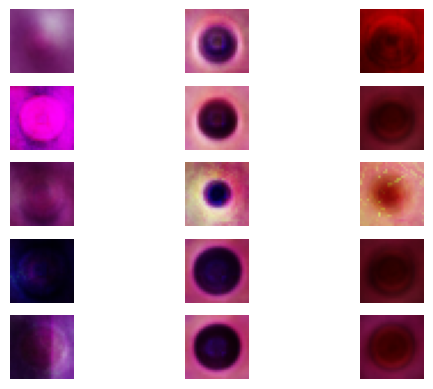

In [29]:
from matplotlib import pyplot as plt
from matplotlib import cm

with torch.no_grad():
    x = net.generate(torch.tensor([list(range(3))] * 5).clone().view(-1))

for i in range(15):
    plt.subplot(5, 3 , i+1)
    plt.axis("off")
    img = x[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
plt.show()